# 3D multi-channel interpolation with local slopes regularization

## Author: M.Ravasi

This notebook applies 3D multi-channel interpolation with local slopes regularization to a 3D shot gather of the SEG/EAGE Overthrust 3D dataset.

The notebook is organized as follows:

- data pre-processing
- multi-channel slope estimation
- 3D single-channel interpolation with sparsity promoting inversion
- 3D multi-channel interpolation with sparsity promoting inversion
- 3D multi-channel interpolation with sparsity promoting inversion and local slopes regularization.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import convolve
from pylops.config import disabled_ndarray_multiplication
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.signalprocessing.patch2d import patch2d_design
from pylops.optimization.leastsquares import regularized_inversion
from pylops.optimization.sparsity import fista
from pylops.utils.wavelets import ricker
from pylops.utils.metrics import snr
from pylops.utils.dottest import dottest

from mcslopes.nmoinv3d import NMO
from mcslopes.plotting import plotting_style, explode_volume
from mcslopes.preprocessing import butter_lowpass_filter, mask, restriction3d, gradient_data3d, gradient_nmo_data3d, fk_filter_design3d
from mcslopes.slopes import multicomponent_slopes_inverse3d

plotting_style()
USE_CUPY = True # use cupy or numpy

In [2]:
if USE_CUPY:
    import cupy as cp
    cp_asarray = cp.asarray
    cp_asnumpy = cp.asnumpy
    np_floatconv = np.float32
    np_floatcconv = np.complex64
    mempool = cp.get_default_memory_pool()
else:
    cp = np
    cp_asarray = np.asarray
    cp_asnumpy = np.asarray
    np_floatconv = np.float64
    np_floatcconv = np.complex128

## Parameters

In [3]:
# pre-processing
apply_nmo = True # apply NMO correction prior to interpolation (True) or not (False)
vnmo = 2000 # NMO velocity (in m/s)
mask_thresh = 0.005 # time-space mask threshold in percentage of max value of data
nfft_t, nfft_y, nfft_x = 2**10, 2**8, 2**8 # lenght of frequency and wavenumber axis (used to compute gradients and perform FK transforms during data reconstruction)

# subsampling
nsub = 5 # subsampling factor

# fk masking
vel = 1800. # velocity
fmax = 75 # maximum frequency
critical = 1.00 # scaling to be applied to the f=k*v line used to create the mask
koffset = 0.001 # shift to be applied to the f=k*v line used to create the mask

# slope estimation
eps_slopeest = 6e2 # regularization factor for smoothing
niter_slopeest = 400 if USE_CUPY else 100 # number of iterations of lsqr

# interpolation
eps_slopes = 1e1 # regularization factor for slope consistency term
eps_fk = 1e-2 # regularization factor for sparsity term
niter = 200 # number of iterations of fista

In [4]:
# Define dictionaries for solvers
dict_slope_opt = dict(iter_lim=niter_slopeest) if not USE_CUPY else dict(niter=niter_slopeest)

## Data loading and preprocessing

We start by loading the data and applying NMO correction (optional)

In [5]:
# Load data
fload = np.load(f'../../data/ove3d_data_forsub{nsub}.npz')
f1load = np.load(f'../../data/ove3d_data_sub{nsub}.npz')
yorig = f1load['yorig']
y = f1load['y']
x = f1load['x']
ys = f1load['ys']
xs = f1load['xs']
t = f1load['t']
dy = yorig[1] - yorig[0]
dx = x[1] - x[0]
dt = t[1] - t[0]

porig = fload['data']
p1orig = fload['grad1']
p = f1load['data']
p1 = f1load['grad1']
nyorig = yorig.size
ny, nx, nt = y.size, x.size, t.size

# Create time gain
gain = (t ** 2)[:, np.newaxis, np.newaxis].T

# Normalize
pmax = p.max() * 0.1

porig /= pmax
p1orig /= pmax
p /= pmax
p1 /= pmax

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


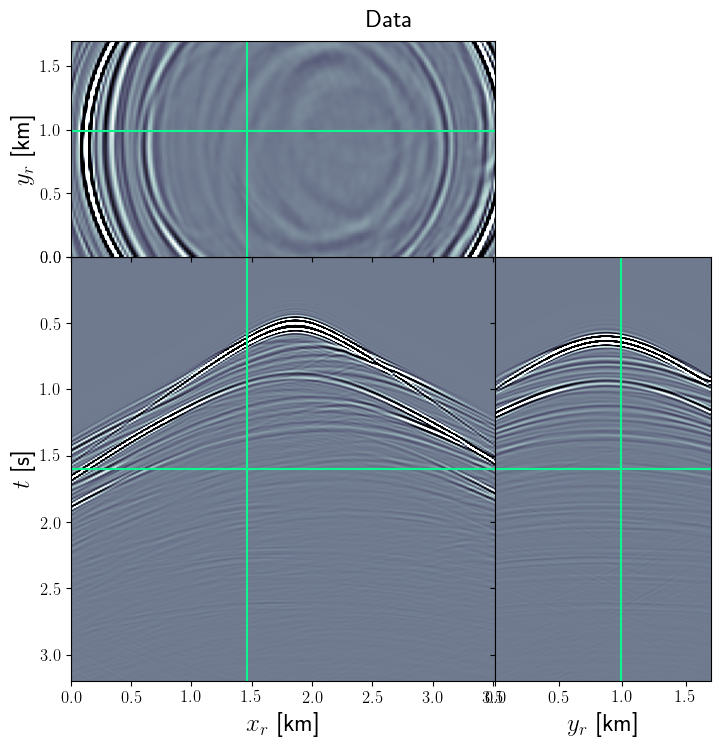

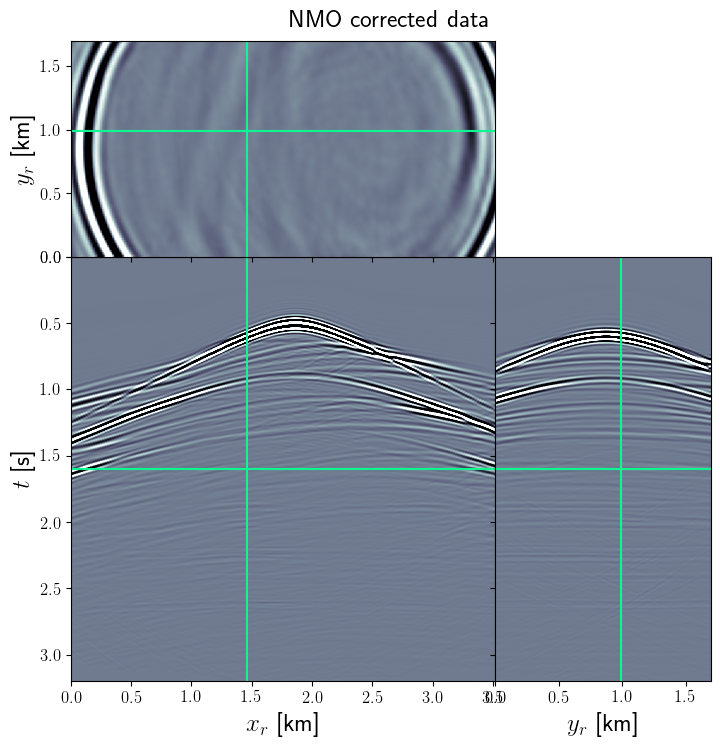

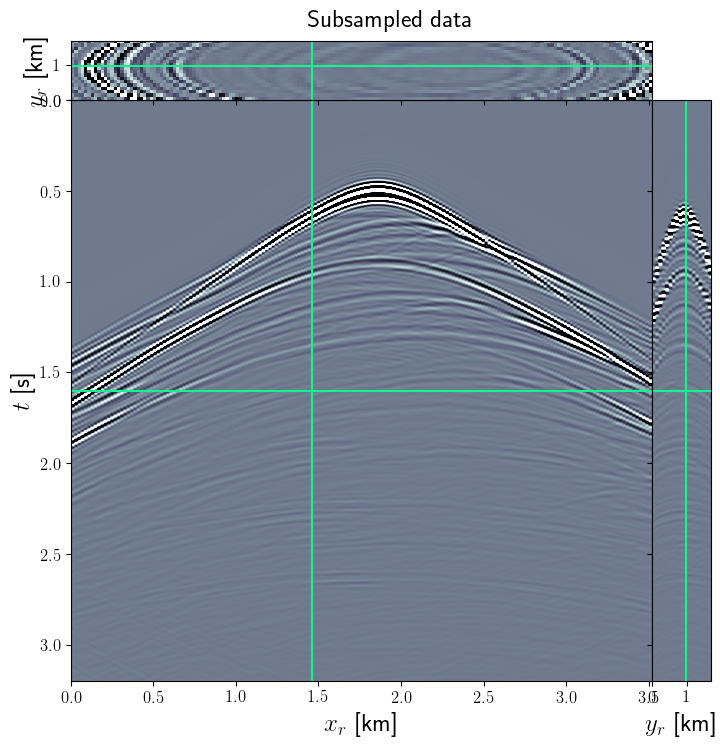

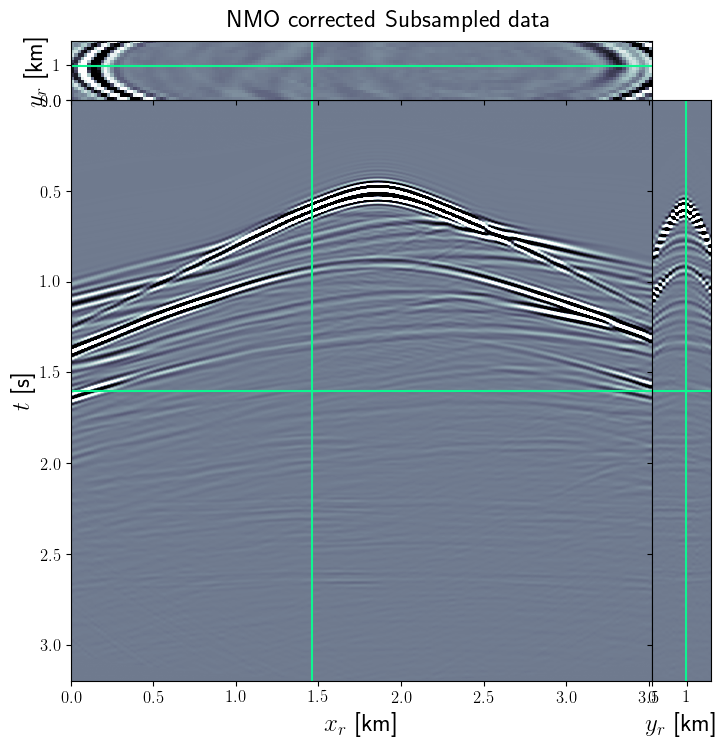

In [6]:
if apply_nmo:
    
    # orig data
    NMOOporig = NMO(t, yorig-ys, x-xs, vnmo * np.ones(nt)) 
    
    porignmo = NMOOporig @ porig
    p1orignmo = gradient_nmo_data3d(porig, p1orig, t, yorig-ys, x-xs, vnmo)[0]

    explode_volume(porig.transpose(2,1,0), x=73, y=52,
                   tlim=[0, t[-1]], tlabel=r'$t$',
                   xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
                   ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
                   labels= ('[s]', '[km]', '[km]'),
                   clipval=(-0.5, 0.5), figsize=(8, 8), 
                   title='Data')
    
    explode_volume(porignmo.transpose(2,1,0), x=73, y=52,
                   tlim=[0, t[-1]], tlabel=r'$t$',
                   xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
                   ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
                   labels= ('[s]', '[km]', '[km]'),
                   clipval=(-0.5, 0.5), figsize=(8, 8), 
                   title='NMO corrected data')
    
    NMOOp = NMO(t, y-ys, x-xs, vnmo * np.ones(nt))
    
    pnmo = NMOOp @ p
    p1nmo = gradient_nmo_data3d(p, p1, t, y-ys, x-xs, vnmo)[0]

    explode_volume(p.transpose(2,1,0), x=73, y=10,
                   tlim=[0, t[-1]], tlabel=r'$t$',
                   xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
                   ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
                   labels= ('[s]', '[km]', '[km]'),
                   clipval=(-0.5, 0.5), figsize=(8, 8), 
                   title='Subsampled data')
    
    explode_volume(pnmo.transpose(2,1,0), x=73, y=10,
                   tlim=[0, t[-1]], tlabel=r'$t$',
                   xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
                   ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
                   labels= ('[s]', '[km]', '[km]'),
                   clipval=(-0.5, 0.5), figsize=(8, 8), 
                   title='NMO corrected Subsampled data')
    
    
    # Overwrite data with nmo corrected data
    pnonmo = p.copy()
    p1nonmo = p1.copy()
    p = pnmo.copy()
    p1 = p1nmo.copy()
    
    porignonmo = porig.copy()
    p1orignonmo = p1orig.copy()
    porig = porignmo.copy()
    p1orig = p1orignmo.copy()

## Data decimation and derivative operators

We proceed now with defining the subsampling strategy and create the derivative operators in FK domain

In [7]:
# Create restriction operator
print('Spatial sampling:', dx*nsub)
Rop = restriction3d(nyorig, nx, nsub, nt)

pgapped = Rop.H @ p

Spatial sampling: 100


In [8]:
_, _, _, _, Fop, D1op, D2op, _, _, _, kys, kxs, f = \
    gradient_data3d(porig, nfft_y, nfft_x, nfft_t, dy, dx, dt, dtype=np_floatcconv, computegraddata=False)

## Time gain 

We can finally apply a time gain to both datasets. This will help both the slope estimation and reconstruction problems to focus on late arrivals

In [9]:
p = p * gain
p1 = p1 * gain
porig = porig * gain
p1orig = p1orig * gain
pgapped = pgapped * gain

if apply_nmo:
    pnonmo = pnonmo * gain
    p1nonmo = p1nonmo * gain
    porignonmo = porignonmo * gain
    p1orignonmo = p1orignonmo * gain
    
sc1 = np.max(np.abs(p)) / np.max(np.abs(p1))

print(f'Scalings for 1st derivative data:{sc1:.2f}')

Scalings for 1st derivative data:30.60


## Time-space mask 

Finally we create a time-space mask to remove any artefact generated by the interpolation process before the first arrival. Note that this could also be used as preconditioner in the reconstruction process directly.

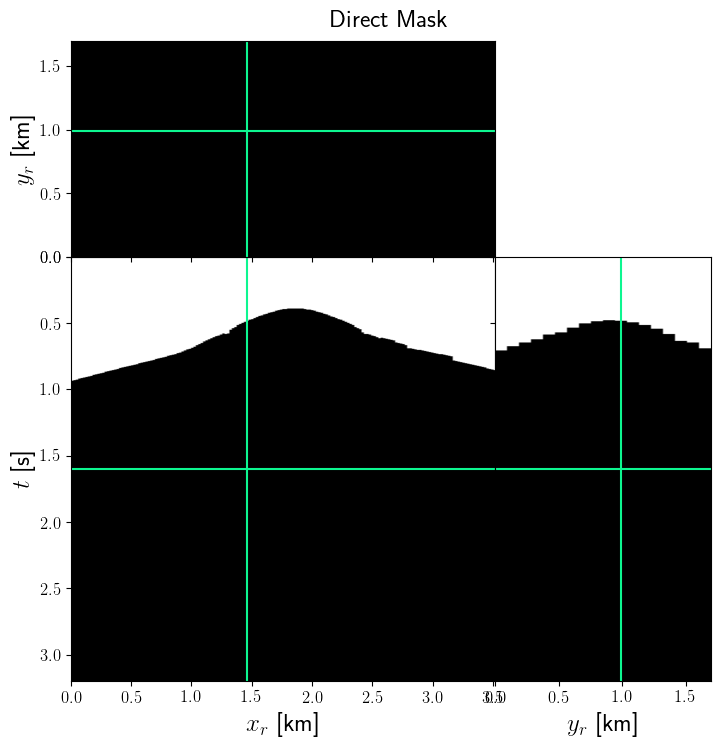

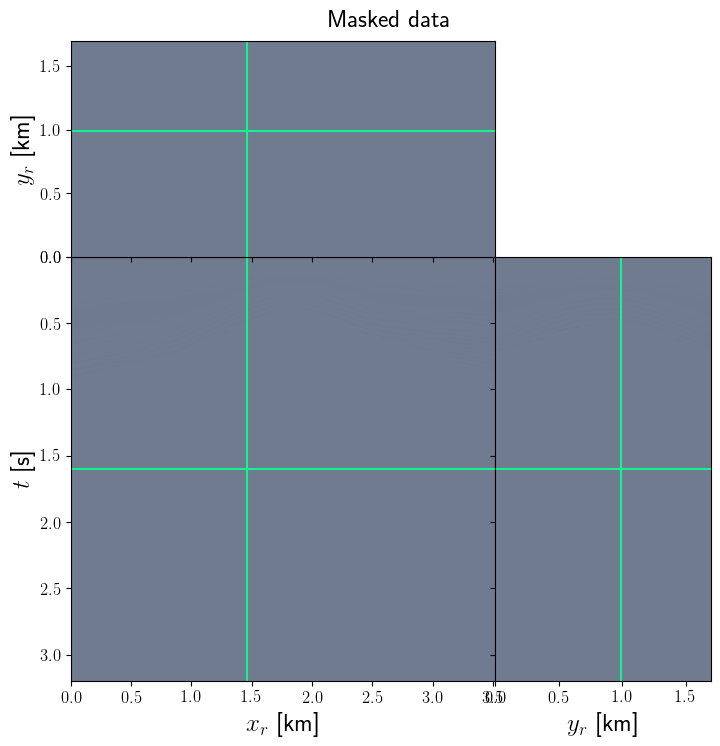

In [10]:
# Calculate time-space mask
direct_mask = mask(pgapped.transpose(1, 0, 2).reshape(nyorig * nx, nt), 
                   mask_thresh * np.max(np.abs(p)), 10).reshape(nx, nyorig, nt).transpose(1, 0, 2)

explode_volume(direct_mask.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'), cmap='gray_r',
               clipval=(0, 1), figsize=(8, 8), 
               title='Direct Mask')    
explode_volume(((1-direct_mask)*porig).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), title='Masked data');

## FK mask design

Finally we design an FK mask that will be used to precondition all reconstruction processes, such that we ensure the reconstruct spectrum to lie within the expected signal cone.

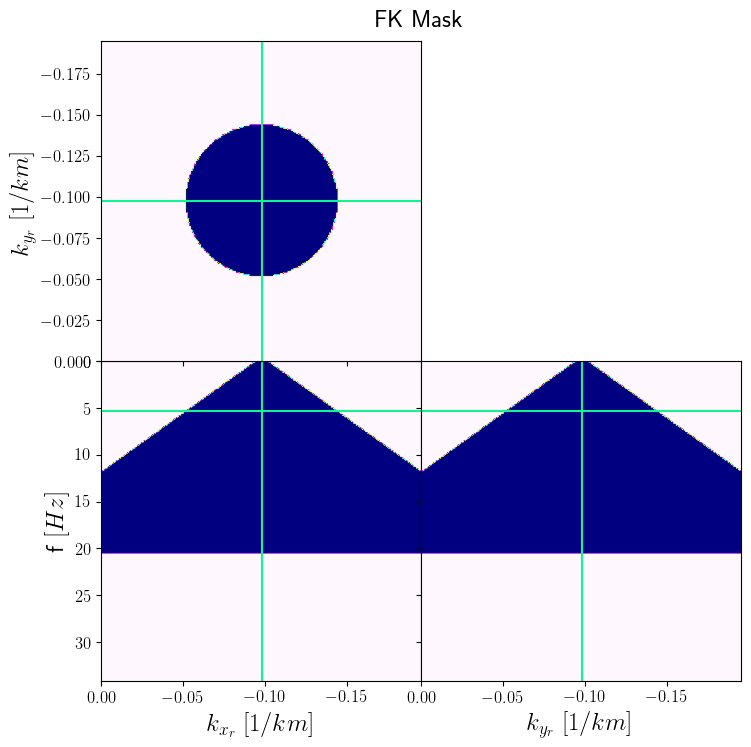

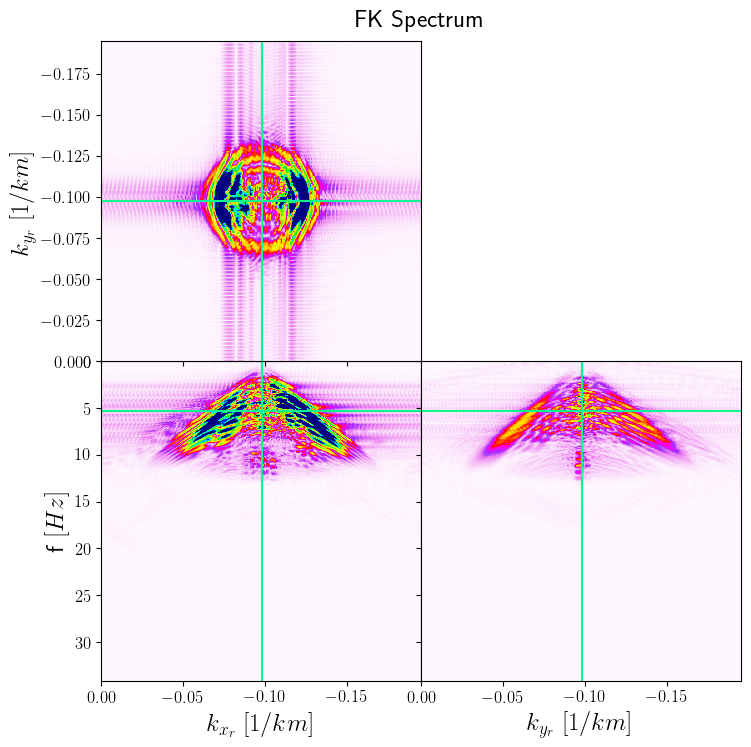

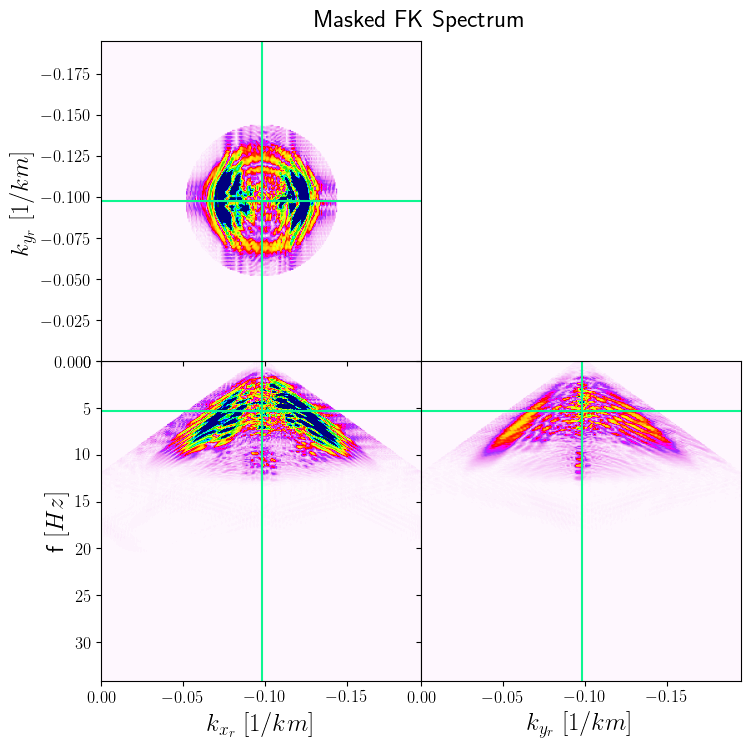

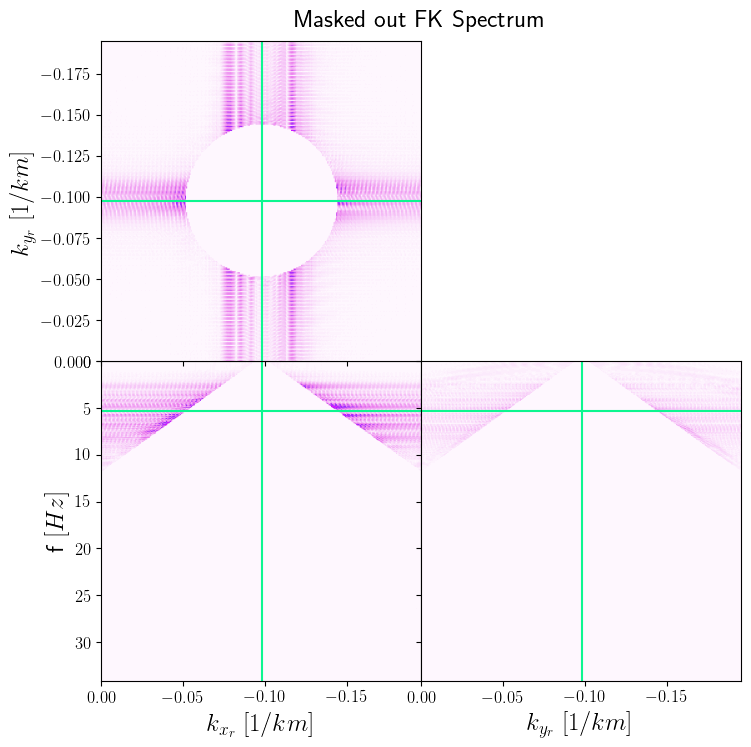

In [11]:
mask_fk = fk_filter_design3d(f, kys, kxs, vel, fmax, critical=critical, koffset=koffset)
Mf = Diagonal(cp_asarray(mask_fk.ravel().astype(np_floatconv)), dtype=np_floatcconv)

P = Fop @ porig

ifmax = 140
explode_volume(np.fft.fftshift(mask_fk, axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 1.), title='FK Mask')

explode_volume(np.fft.fftshift(np.abs(P), axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 2.), title='FK Spectrum')

explode_volume(np.fft.fftshift(np.abs(mask_fk * P), axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 2.), title='Masked FK Spectrum')

explode_volume(np.fft.fftshift(np.abs((1 - mask_fk) * P), axes=(0,1)).transpose(2, 1, 0), t=80,
               tlim=[0,f[ifmax]], tlabel='f',
               xlim=[1e3*kxs[0], 1e3*kxs[-1]], xlabel=r'$k_{x_r}$',
               ylim=[1e3*kys[0], 1e3*kys[-1]], ylabel=r'$k_{y_r}$',
               labels= (r'$[Hz]$', r'$[1/km]$', r'$[1/km]$'),                   
               cmap='gist_ncar_r', figsize=(8, 8), 
               clipval=(0, 2.), title='Masked out FK Spectrum');

## Multi-channel slope estimation

We are now ready to estimate local slopes using our synthetically created multi-channel data. We will do it first for the fully sampled data (this will be our benchmark) and then for the sparsely sampled data.

In [12]:
slope_mc, weight = multicomponent_slopes_inverse3d(Rop.H @ cp_asarray(p), dy, dt, 
                                                   graddata=Rop.H @ cp_asarray(p1), Rop=Rop,
                                                   reg=eps_slopeest, **dict_slope_opt)

slope_mc, weight = cp_asnumpy(slope_mc), cp_asnumpy(weight)

## 3D single-channel interpolation with sparsity promoting inversion

In [13]:
data0 = cp_asarray(p.ravel().astype(np_floatconv))
F0op = Rop * Fop.H * Mf

with disabled_ndarray_multiplication():
    pinv0, _, _ = fista(F0op, data0.ravel(), niter=niter, eps=eps_fk, 
                        eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv0 = cp_asnumpy(np.real(Fop.H * Mf * pinv0)).reshape(nyorig, nx, nt)

del pinv0
mempool.free_all_blocks()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 2551986 rows and 33619968 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 1.097001e+00	thresh = 5.485003e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    2.932e+04   3.345e+04   3.881e+02
     2   0.00e+00+0.00e+00j    9.772e+03   1.538e+04   1.659e+02
     3   0.00e+00+0.00e+00j    3.107e+03   9.569e+03   1.100e+02
     4   0.00e+00+0.00e+00j    1.073e+03   7.954e+03   6.903e+01
     5   0.00e+00+0.00e+00j    4.576e+02   7.511e+03   4.317e+01
     6   0.00e+00+0.00e+00j    2.549e+02   7.355e+03   2.828e+01
     7   0.00e+00+0.00e+00j    1.879e+02   7.280e+03   1.959e+01
     8   0.00e+00+0.00e+00j    1.715e+02   7.235e+03   1.390e+01
     9   0.00e+00+0.00e+00j    1.677e+02   7.196e+03   1.056e+01
    10   0.00e+00+

## 3D multi-channel interpolation with sparsity promoting inversion

In [14]:
F1op = VStack([Rop*Fop.H, sc1*Rop*Fop.H*D1op,]) * Mf
data1 = cp_asarray(np.concatenate((p.ravel(), sc1*p1.ravel()), axis=0).astype(np_floatconv))

pinv1, _, _ = fista(F1op, data1, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)

dinv1 = cp_asnumpy(np.real(Fop.H * Mf * pinv1)).reshape(nyorig, nx, nt)

del pinv1
mempool.free_all_blocks()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 5103972 rows and 33619968 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 1.303422e-01	thresh = 6.517111e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.632e+05   1.641e+05   8.189e+01
     2   0.00e+00+0.00e+00j    1.353e+05   1.369e+05   6.277e+01
     3   0.00e+00+0.00e+00j    1.105e+05   1.128e+05   6.698e+01
     4   0.00e+00+0.00e+00j    8.896e+04   9.199e+04   6.898e+01
     5   0.00e+00+0.00e+00j    7.066e+04   7.437e+04   6.953e+01
     6   0.00e+00+0.00e+00j    5.531e+04   5.967e+04   6.898e+01
     7   0.00e+00+0.00e+00j    4.259e+04   4.758e+04   6.754e+01
     8   0.00e+00+0.00e+00j    3.221e+04   3.778e+04   6.538e+01
     9   0.00e+00+0.00e+00j    2.390e+04   3.001e+04   6.257e+01
    10   0.00e+00+

## 3D multi-channel interpolation with sparsity promoting inversion and local slopes regularization

In [15]:
# Let's start by setting the slope regularization term
D1op0 = FirstDerivative(dims=(nyorig, nx, nt), axis=0, sampling=dy, order=5, edge=True, dtype=np_floatcconv)
D1op1 = FirstDerivative(dims=(nyorig, nx, nt), axis=2, sampling=dt, order=5, edge=True, dtype=np_floatcconv)

slope_D1op1 = Diagonal(cp_asarray(slope_mc.ravel()).astype(np_floatconv)) * D1op1
SRegop = D1op0 + slope_D1op1

In [16]:
F2op = VStack([Rop*Fop.H, 
               sc1*Rop*Fop.H*D1op,
               eps_slopes * SRegop * Fop.H]) * Mf
data2 = cp_asarray(np.concatenate((p.ravel(), sc1*p1.ravel(), np.zeros(nyorig*nx*nt)), axis=0).astype(np_floatconv))

pinv2, _, _ = fista(F2op, data2, niter=niter, eps=eps_fk, 
                    eigsdict=dict(niter=5, tol=1e-2), show=True)
dinv2 = cp_asnumpy(np.real(Fop.H * Mf * pinv2)).reshape(nyorig, nx, nt)

del pinv2
mempool.free_all_blocks()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 17863902 rows and 33619968 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 1.253379e-01	thresh = 6.266894e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.656e+05   1.665e+05   7.875e+01
     2   0.00e+00+0.00e+00j    1.401e+05   1.416e+05   5.890e+01
     3   0.00e+00+0.00e+00j    1.173e+05   1.195e+05   6.285e+01
     4   0.00e+00+0.00e+00j    9.747e+04   1.003e+05   6.488e+01
     5   0.00e+00+0.00e+00j    8.058e+04   8.409e+04   6.549e+01
     6   0.00e+00+0.00e+00j    6.642e+04   7.055e+04   6.496e+01
     7   0.00e+00+0.00e+00j    5.471e+04   5.942e+04   6.356e+01
     8   0.00e+00+0.00e+00j    4.514e+04   5.038e+04   6.153e+01
     9   0.00e+00+0.00e+00j    3.736e+04   4.309e+04   5.907e+01
    10   0.00e+00

## Restore data (aka INMO correction)

Finally, if NMO correction was applied to the data prior to interpolation, we restore the data to their original domain

In [17]:
if apply_nmo:
    porig = NMOOporig.div(porig.ravel(), niter=5).reshape(porig.shape)
    p = NMOOporig.div(pgapped.ravel(), niter=5).reshape(porig.shape)
    dinv0 = NMOOporig.div(dinv0.ravel(), niter=5).reshape(porig.shape)
    dinv1 = NMOOporig.div(dinv1.ravel(), niter=5).reshape(porig.shape)
    dinv2 = NMOOporig.div(dinv2.ravel(), niter=5).reshape(porig.shape)

## Comparison

In [18]:
snr_pmask = snr(porig, p)
snr_dinv0 = snr(porig, direct_mask*dinv0)
snr_dinv1 = snr(porig, direct_mask*dinv1)
snr_dinv2 = snr(porig, direct_mask*dinv2)

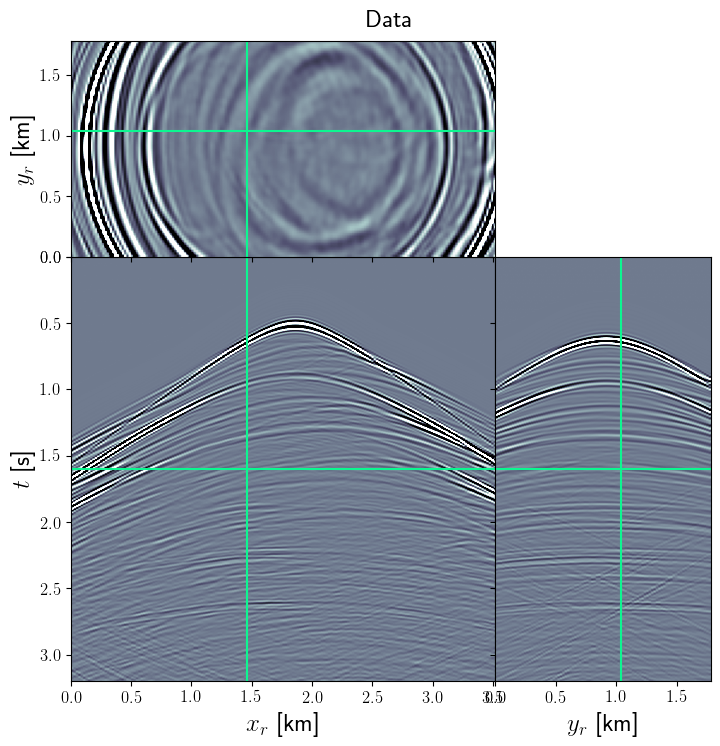

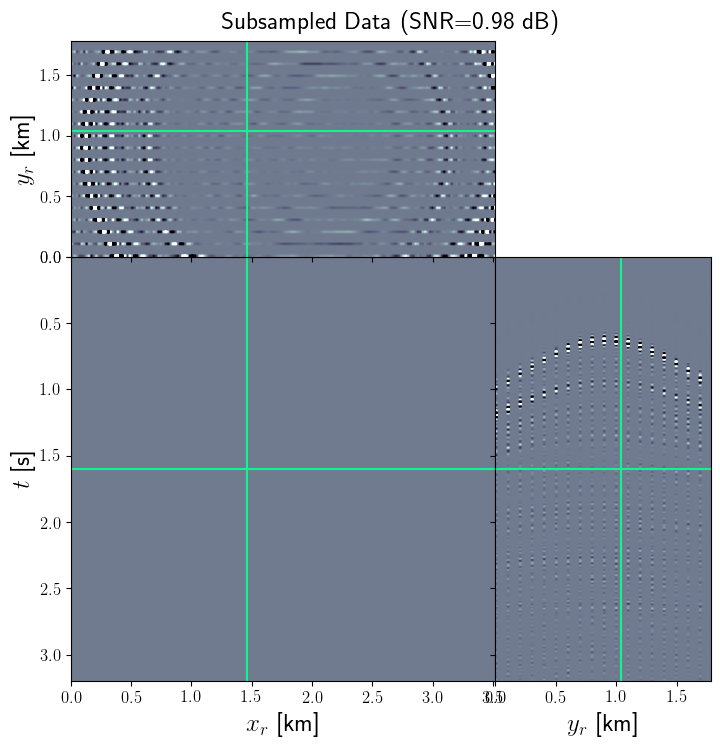

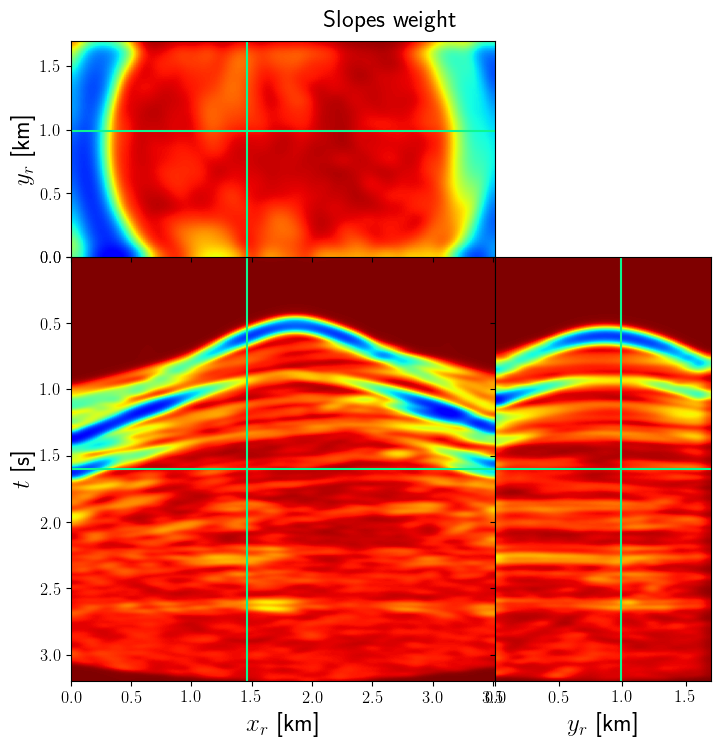

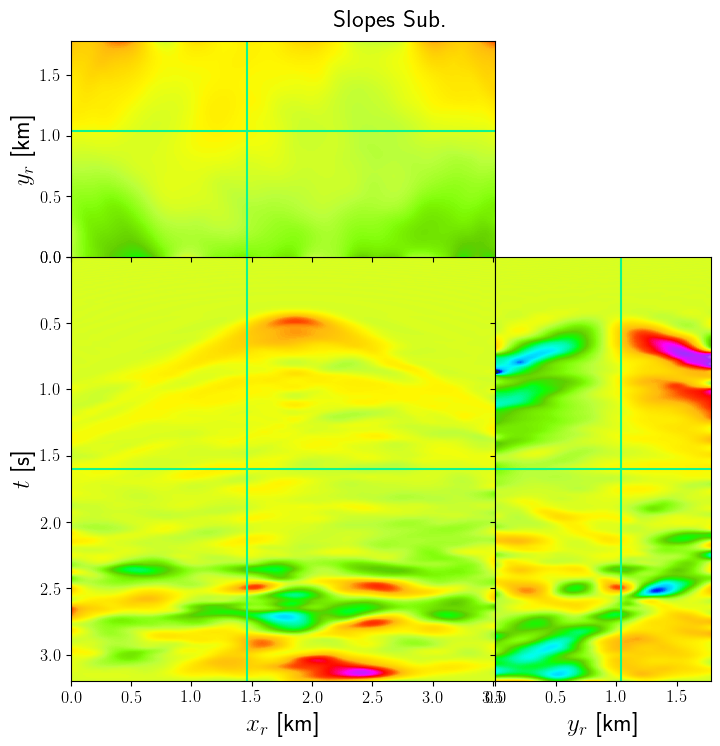

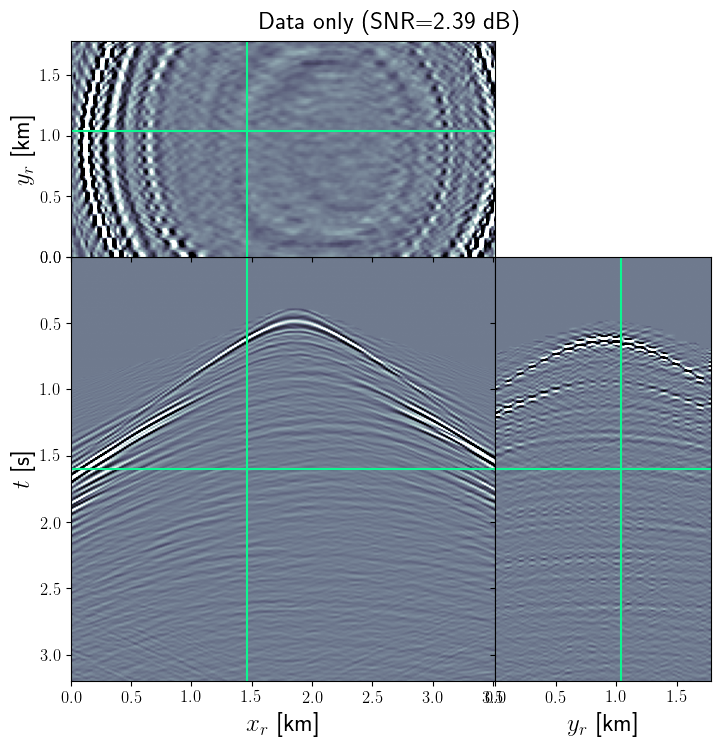

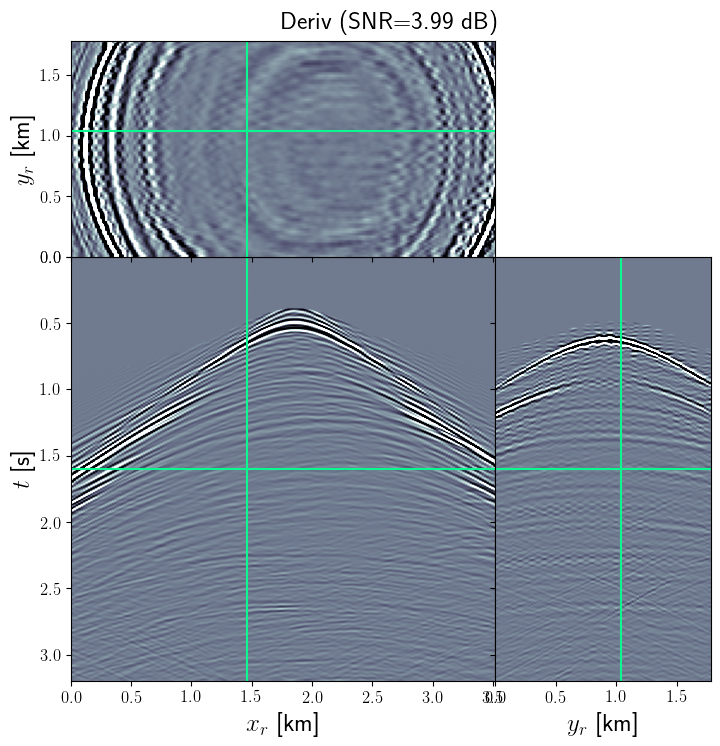

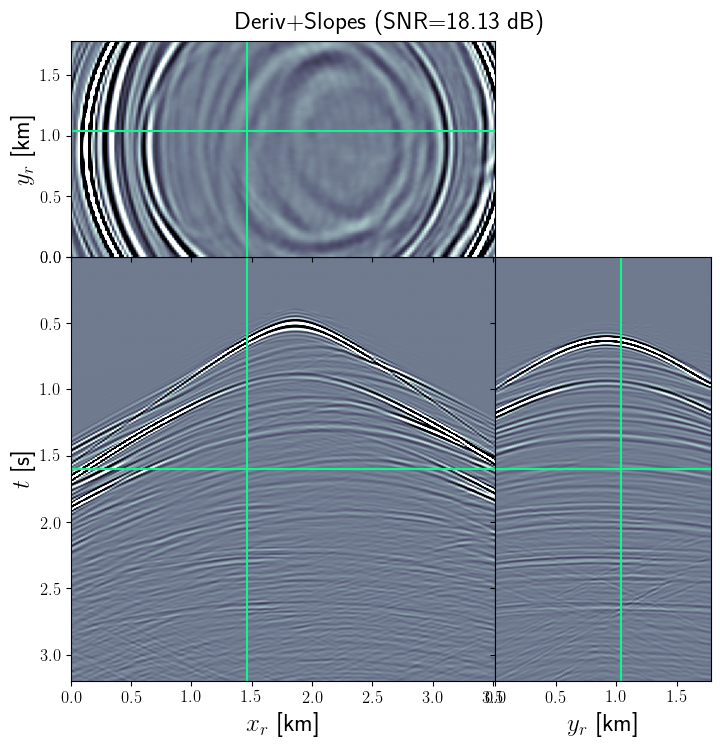

In [19]:
explode_volume(porig.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[yorig[0]/1e3, yorig[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Data')

explode_volume(p.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[yorig[0]/1e3, yorig[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Subsampled Data (SNR={snr_pmask:.2f} dB)')

explode_volume(weight.transpose(2,1,0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'), cmap='jet',
               clipval=(0, 10), figsize=(8, 8), 
               title='Slopes weight')

explode_volume(slope_mc.transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[yorig[0]/1e3, yorig[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-1/vel, 1/vel), figsize=(8, 8), cmap='gist_ncar',
               title=f'Slopes Sub.')

explode_volume((direct_mask*dinv0).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[yorig[0]/1e3, yorig[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Data only (SNR={snr_dinv0:.2f} dB)')

explode_volume((direct_mask*dinv1).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[yorig[0]/1e3, yorig[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Deriv (SNR={snr_dinv1:.2f} dB)')

explode_volume((direct_mask*dinv2).transpose(2, 1, 0), x=73, y=52,
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
               ylim=[yorig[0]/1e3, yorig[-1]/1e3], ylabel=r'$y_r$',
               labels= ('[s]', '[km]', '[km]'),
               clipval=(-0.5, 0.5), figsize=(8, 8), 
               title=f'Deriv+Slopes (SNR={snr_dinv2:.2f} dB)');